# LSTM for Trajectory Prediction

The model architecture for trajectory prediction consists of the following components:
- A CNN for processing the heightmap
- A dense layer for processing the robot state and control inputs
- An LSTM for sequential processing
- An output layer for predicting the next state

The heightmap is processed by a CNN to extract features.
The robot state and control inputs are concatenated and processed by a dense layer.
The heightmap features and processed robot state/control features are concatenated and passed through an LSTM.
The LSTM output is passed through an output layer to predict the next state.

In [1]:
import torch
import torch.nn as nn
from monoforce.models.traj_predictor.lstm import TrajectoryLSTM

# Model Instantiation and Forward Pass

Let's instantiate the model and perform a forward pass to predict the next state.

In [2]:
# Model Parameters
state_features = 6  # Example: (x, y, z, roll, pitch, yaw)
control_features = 2  # Example: (v_cmd, w_cmd)
heightmap_shape = (128, 128)  # Example: Heightmap of size 64x64

# Instantiate the model
model = TrajectoryLSTM(state_features, control_features, heightmap_shape)

# Print model summary
print(model)

TrajectoryLSTM(
  (heightmap_cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (robot_state_nn): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
  )
  (lstm): LSTM(16400, 256, batch_first=True)
  (output_fc): Linear(in_features=256, out_features=6, bias=True)
)


# Example inputs

Let's create some example inputs for the model and perform a forward pass.

The model expects the following inputs:
- Robot state: A tensor of shape (batch_size, seq_len, state_features)
- Control inputs: A tensor of shape (batch_size, seq_len, control_features)
- Heightmap: A tensor of shape (batch_size, 1, heightmap_height, heightmap_width)

The model predicts the next states as a tensor of shape (batch_size, seq_len, output_size).

In [3]:
# Example inputs
batch_size = 1
T, dt = 5.0, 0.01
seq_len = int(T / dt)

robot_state = torch.randn(batch_size, state_features)  # Robot state at the initial time step
print("Robot state shape:", robot_state.shape)
control_inputs = torch.randn(batch_size, seq_len, control_features)  # Control commands
print("Control inputs shape:", control_inputs.shape)
heightmap = torch.randn(batch_size, 1, *heightmap_shape)  # Single heightmap per batch
print("Heightmap shape:", heightmap.shape)

# Forward pass
output = model(robot_state, control_inputs, heightmap)

# Output shape
print("Output shape:", output.shape)  # Should be (batch_size, seq_len, state_features)

Robot state shape: torch.Size([1, 6])
Control inputs shape: torch.Size([1, 500, 2])
Heightmap shape: torch.Size([1, 1, 128, 128])
Output shape: torch.Size([1, 500, 6])


# Model Inference

We will use the ROUGH dataset to perform inference using the model.

In [4]:
from monoforce.datasets import ROUGH, rough_seq_paths
from scipy.spatial.transform import Rotation

class Data(ROUGH):
    def __init__(self, path, is_train=False):
        super(Data, self).__init__(path, is_train=is_train)

    def get_sample(self, i):
        control_ts, controls = self.get_controls(i)
        
        traj = self.get_traj(i)
        traj_ts = traj['stamps']
        traj_ts  = torch.as_tensor(traj_ts - traj_ts[0], dtype=torch.float32)
        
        poses = traj['poses']
        xyz = torch.as_tensor(poses[:, :3, 3], dtype=torch.float32)
        Rs = poses[:, :3, :3]
        rpy = torch.as_tensor(Rotation.from_matrix(Rs).as_euler('xyz'), dtype=torch.float32)
        states = torch.cat((xyz, rpy), dim=-1)
        
        hm = self.get_geom_height_map(i)[0:1]
        return (hm,
                control_ts, controls,
                traj_ts, states)

In [5]:
ds = Data(rough_seq_paths[0])
print(len(ds))

1016


/home/ruslan/miniconda3/envs/mf/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538437738/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using sample: 439
Loaded pretrained weights for efficientnet-b0


  0%|          | 0/1 [00:00<?, ?it/s]

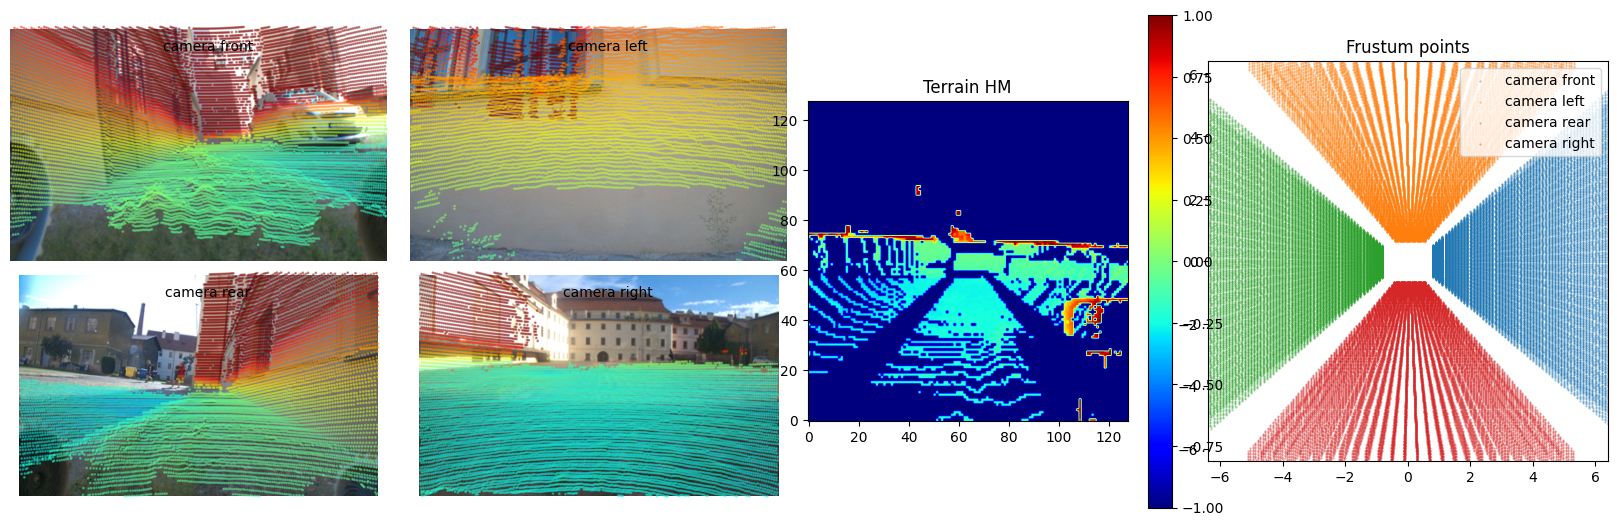

100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


In [6]:
%matplotlib inline
from monoforce.utils import explore_data
import numpy as np

# sample_i = 120
sample_i = np.random.choice(len(ds))
print(f'Using sample: {sample_i}')
explore_data(ds, [sample_i])

In [7]:
# Inference
sample = ds[sample_i]
batch = [s[None] for s in sample]
hm, control_ts, controls, traj_ts, xyz_rpy = batch
print("Heightmap shape:", hm.shape)
print("Controls shape:", controls.shape)
print("Robot states shape:", xyz_rpy.shape)

xyz_rpy0 = xyz_rpy[:, 0]
output = model(xyz_rpy0, controls, hm)
print("Output trajectory shape:", output.shape)  # Should be (batch_size, seq_len, output_size)

Heightmap shape: torch.Size([1, 1, 128, 128])
Controls shape: torch.Size([1, 500, 2])
Robot states shape: torch.Size([1, 50, 6])
Output trajectory shape: torch.Size([1, 500, 6])


# Model Training

Iter 1/1000, Loss: 1.5289


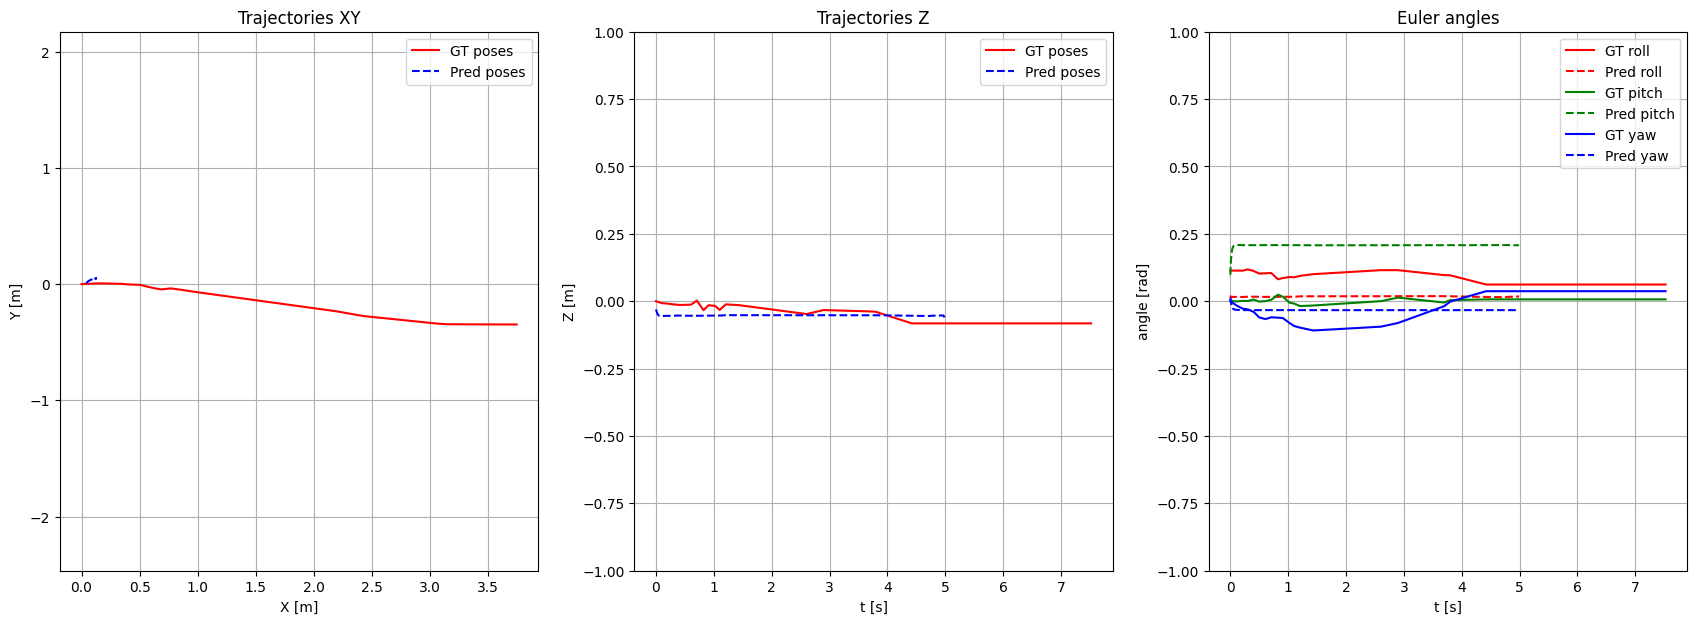

Iter 101/1000, Loss: 0.3246


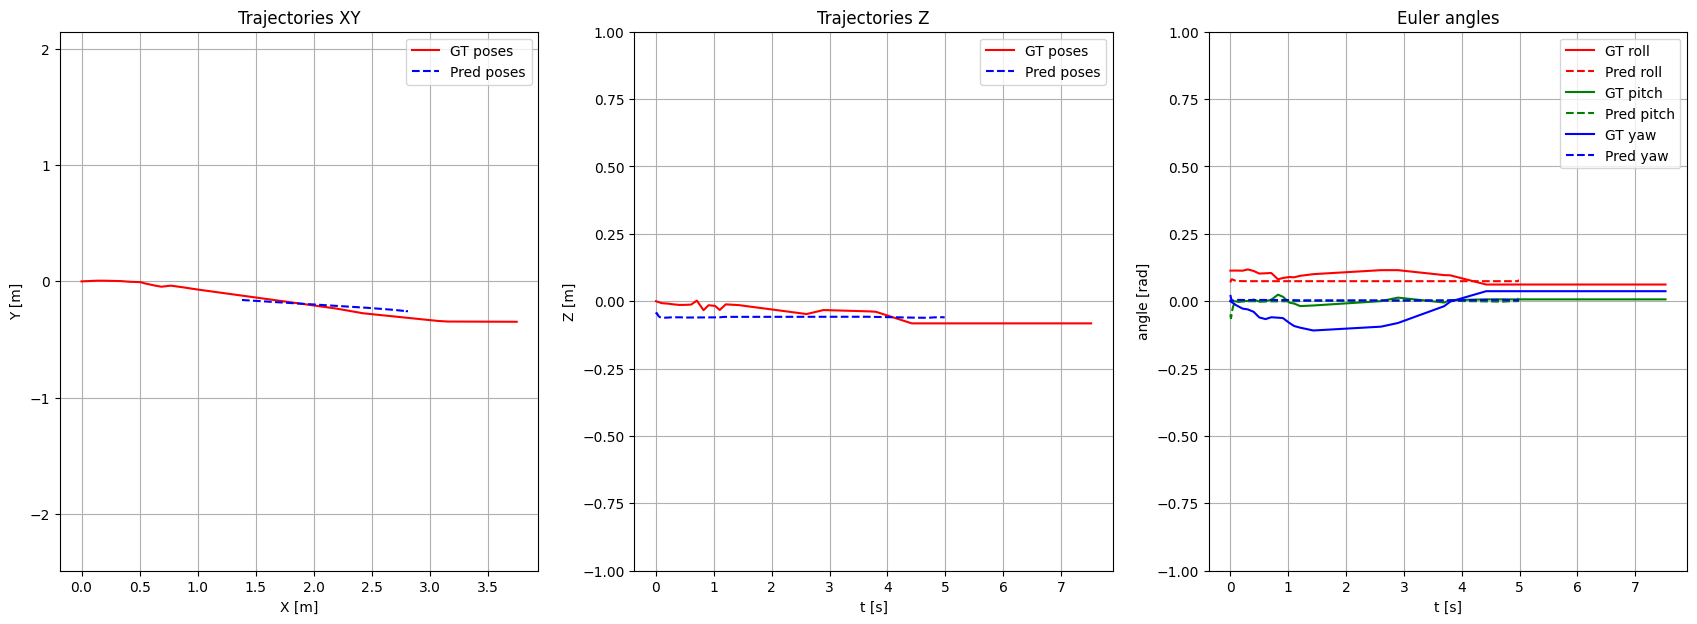

Iter 201/1000, Loss: 0.3098


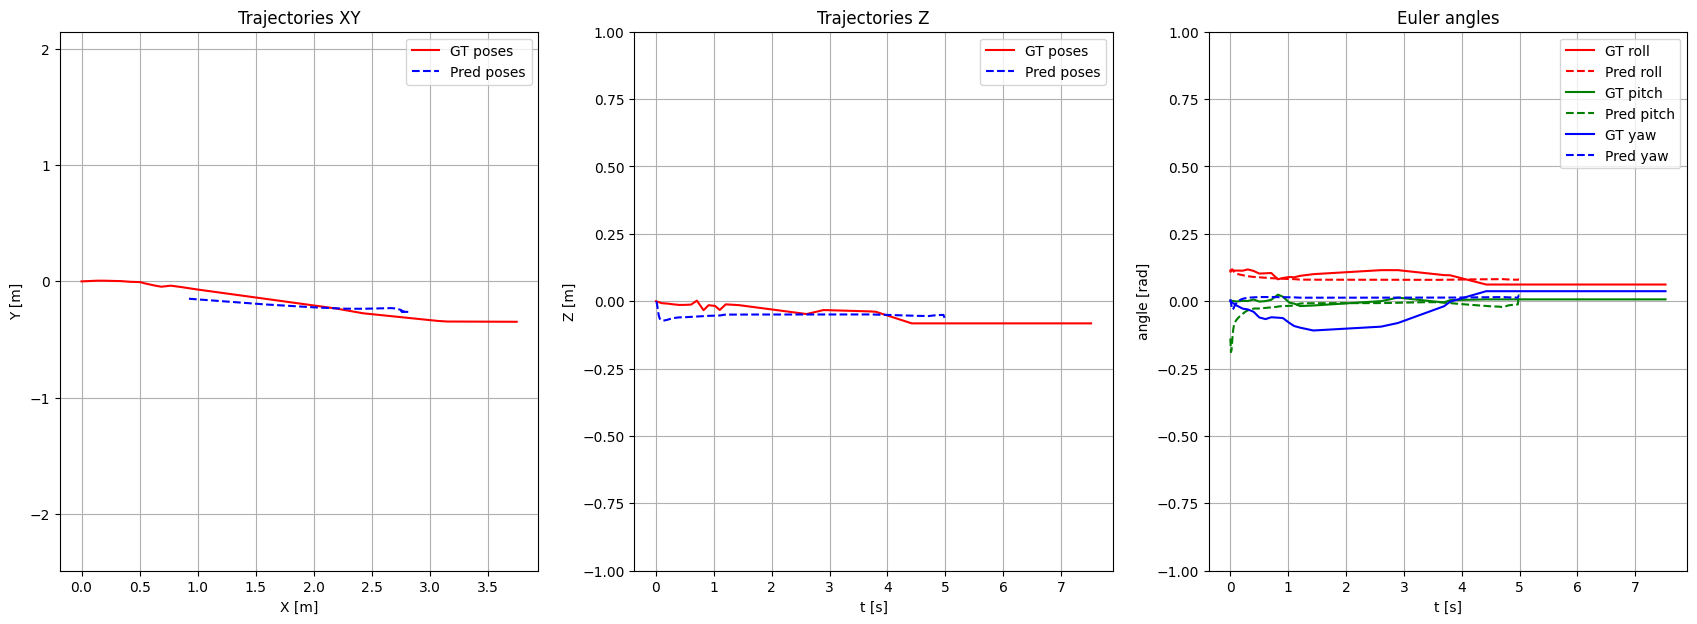

Iter 301/1000, Loss: 0.1789


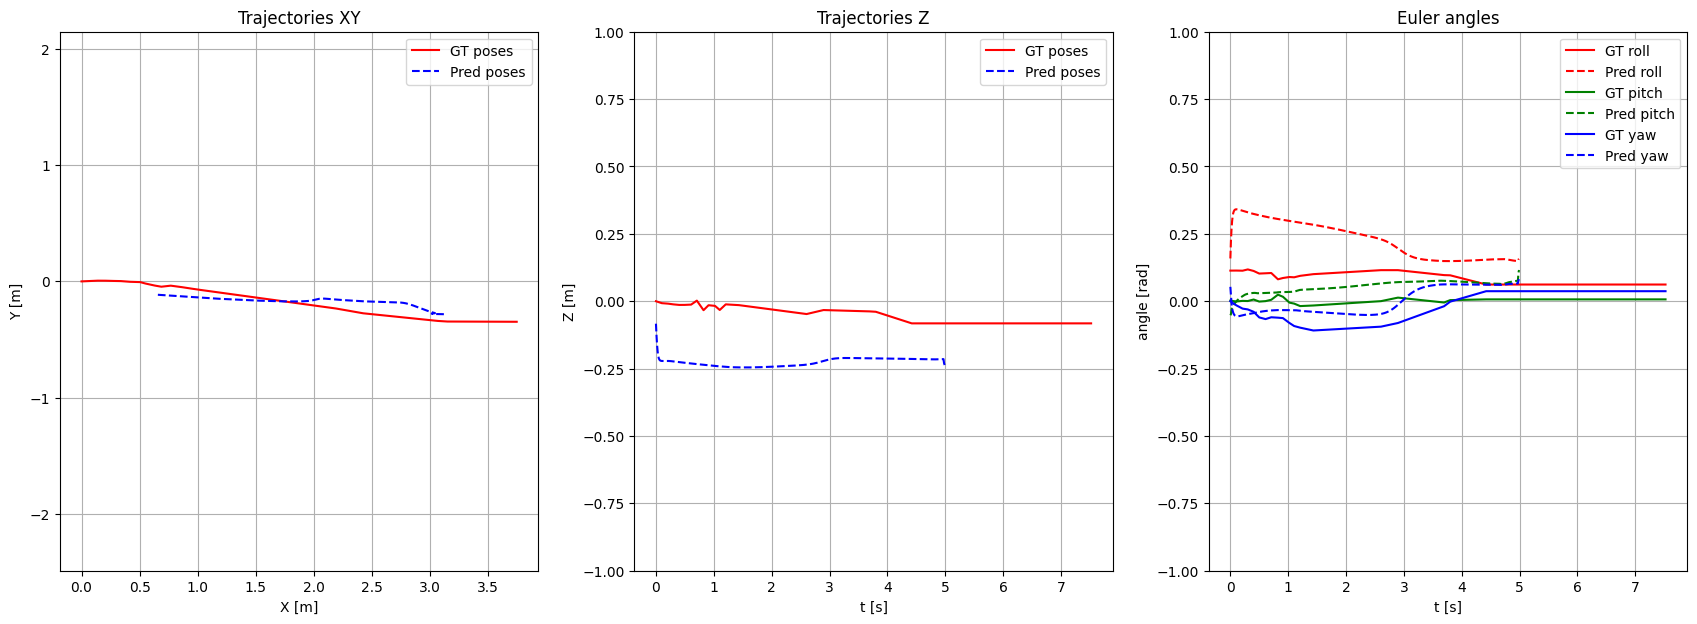

Iter 401/1000, Loss: 0.1292


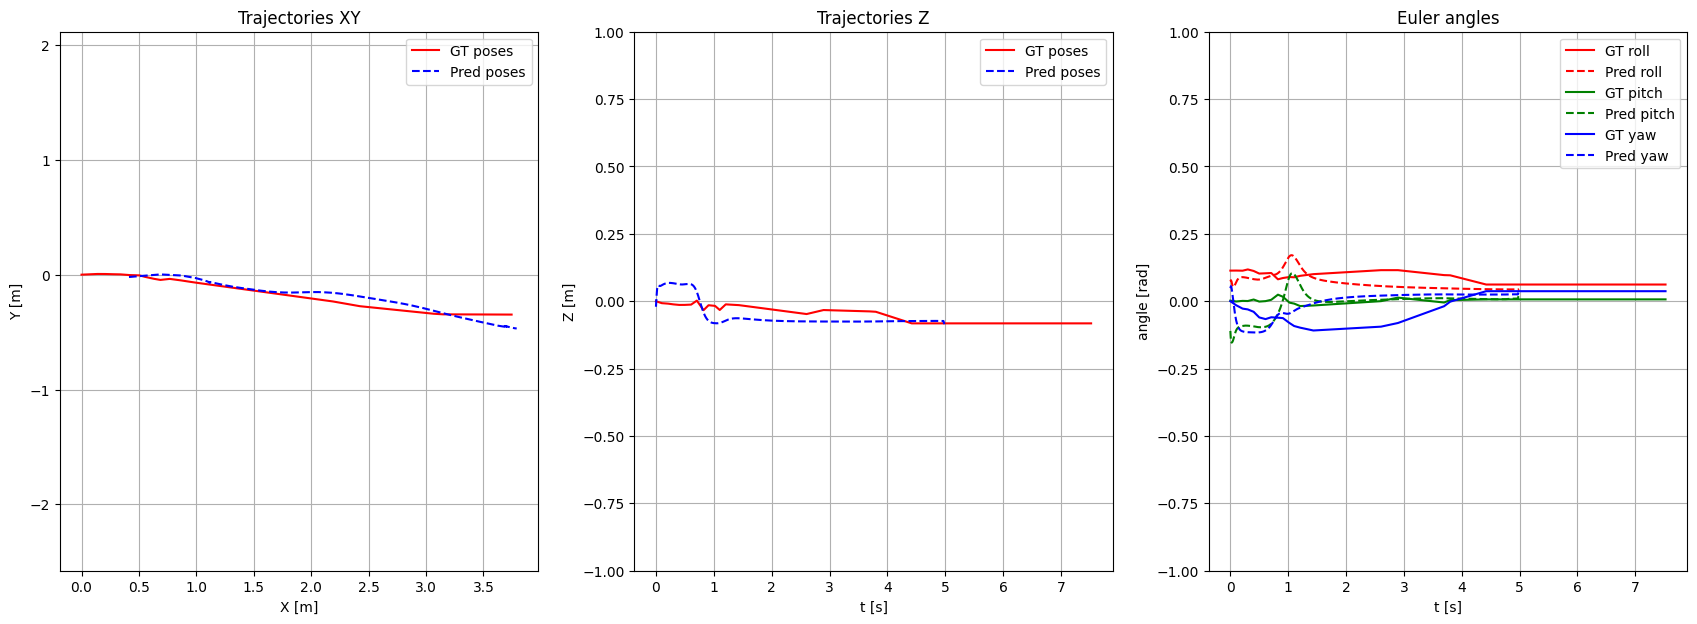

Iter 501/1000, Loss: 0.0013


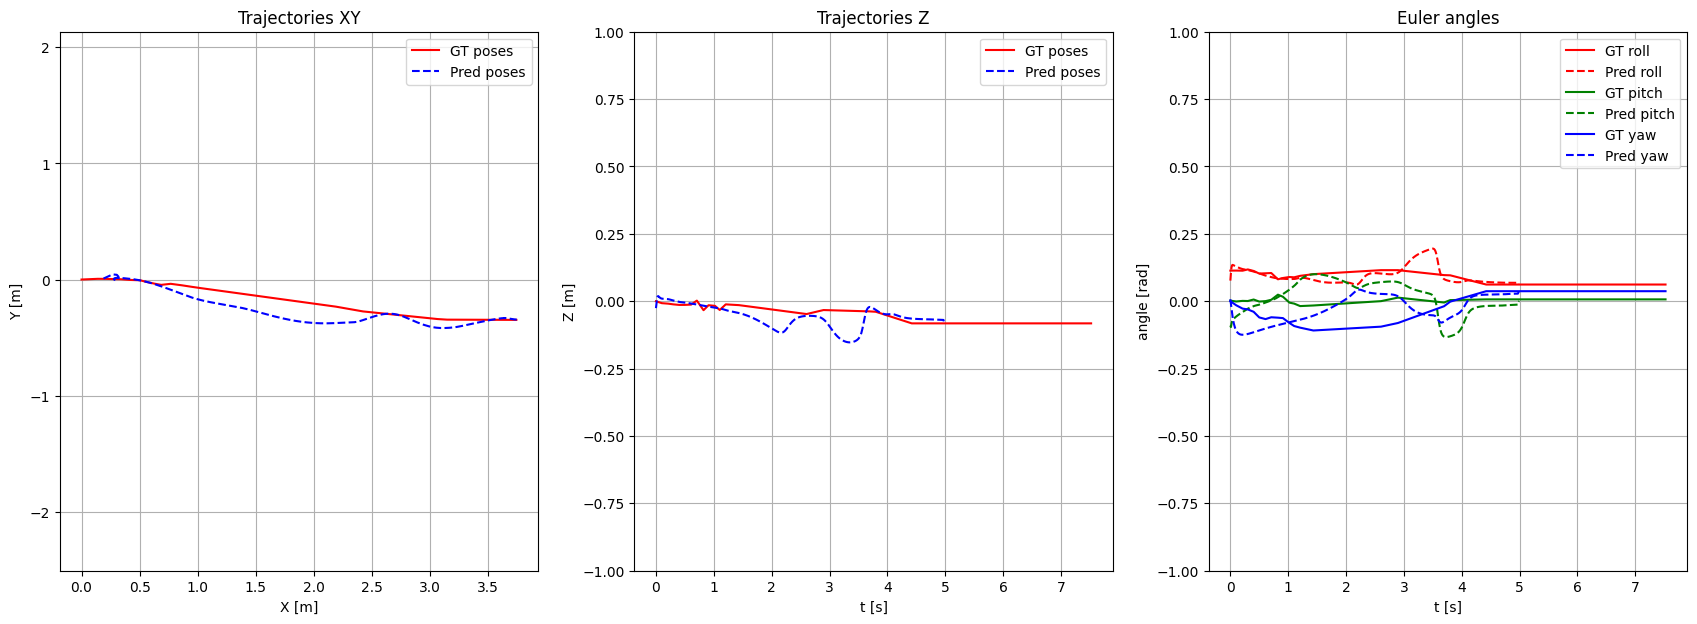

Iter 601/1000, Loss: 0.0006


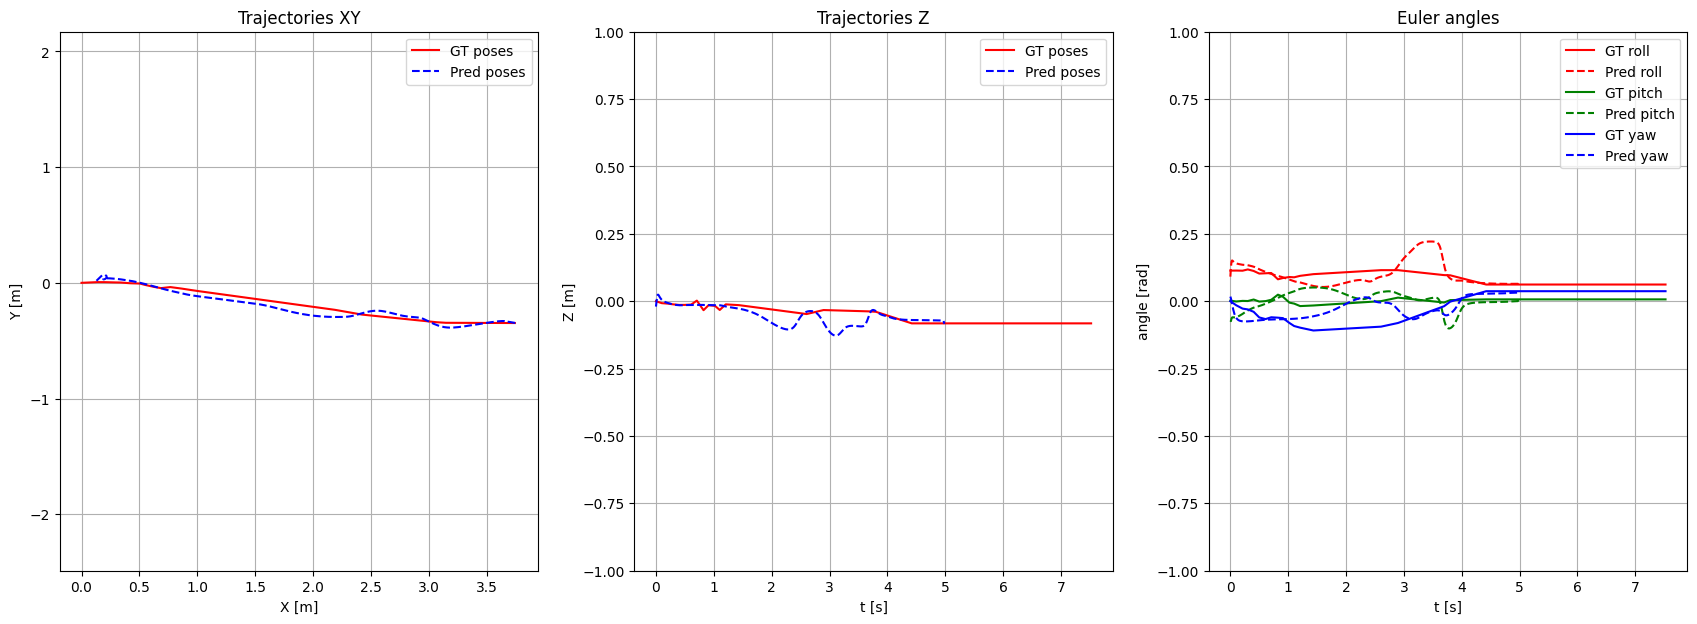

Iter 701/1000, Loss: 0.0004


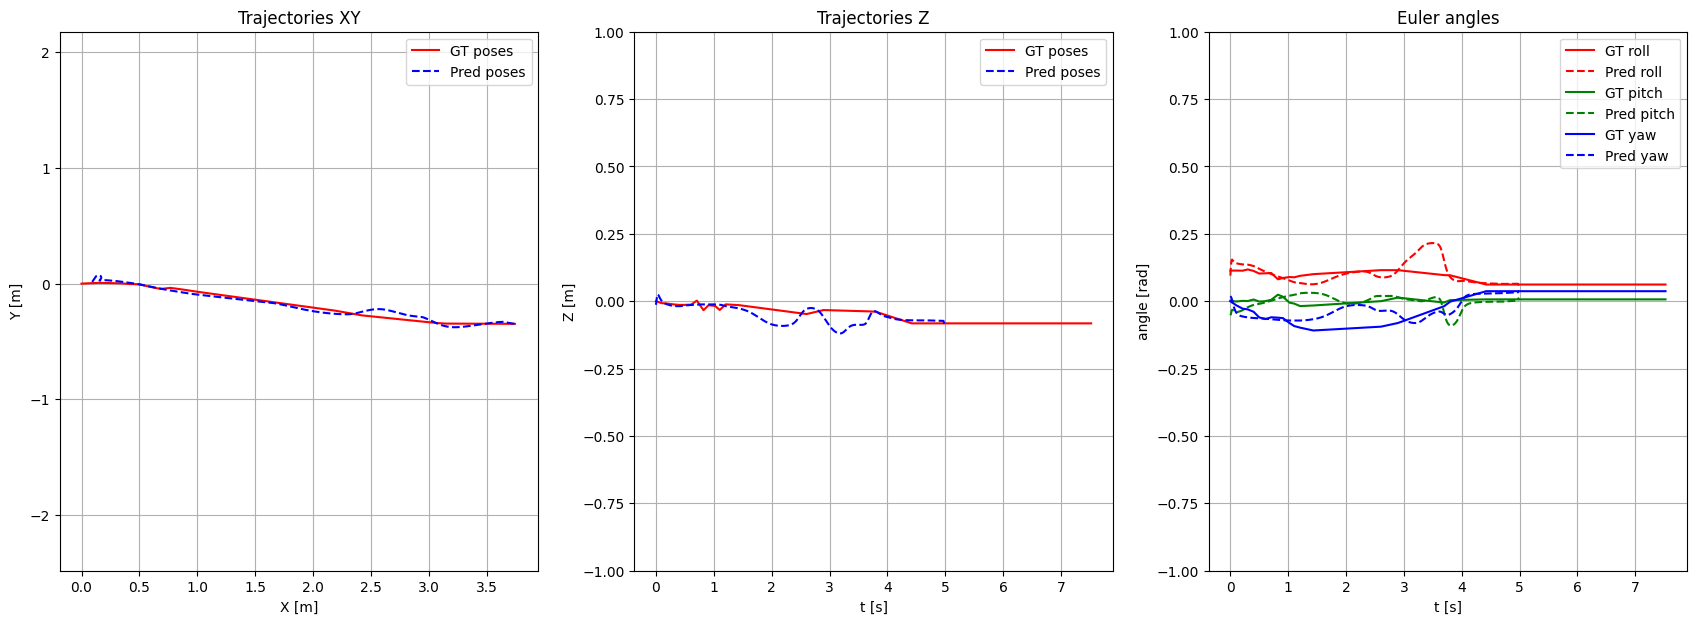

Iter 801/1000, Loss: 0.0003


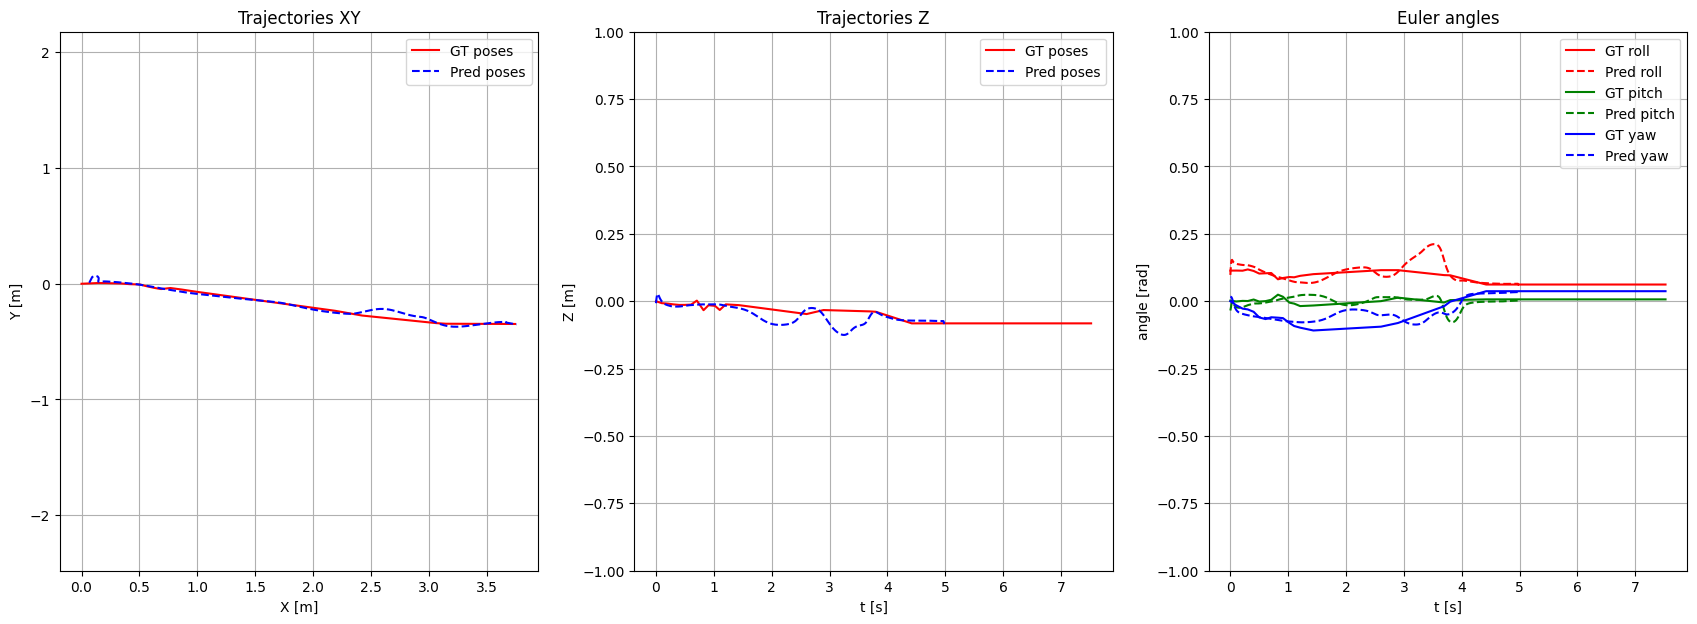

Iter 901/1000, Loss: 0.0002


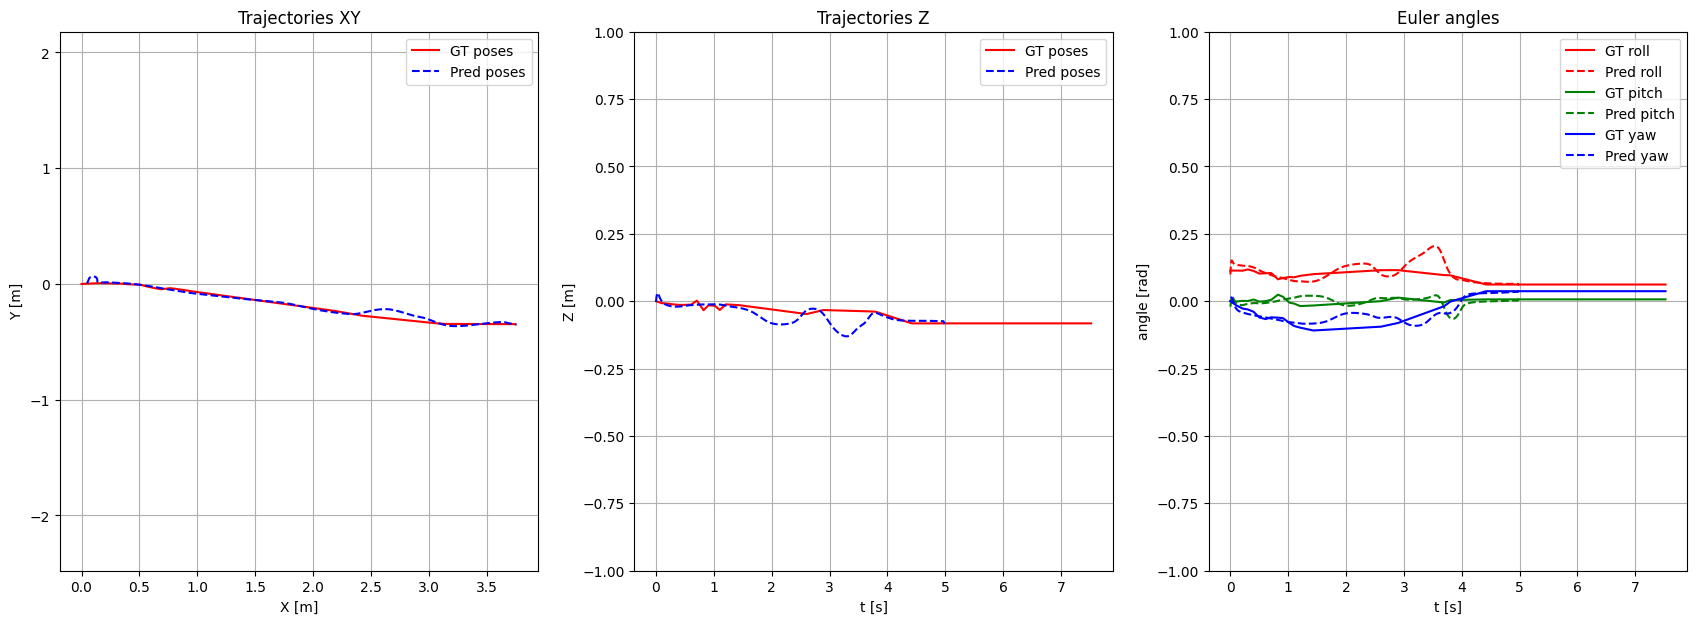

Iter 1000/1000, Loss: 0.0002


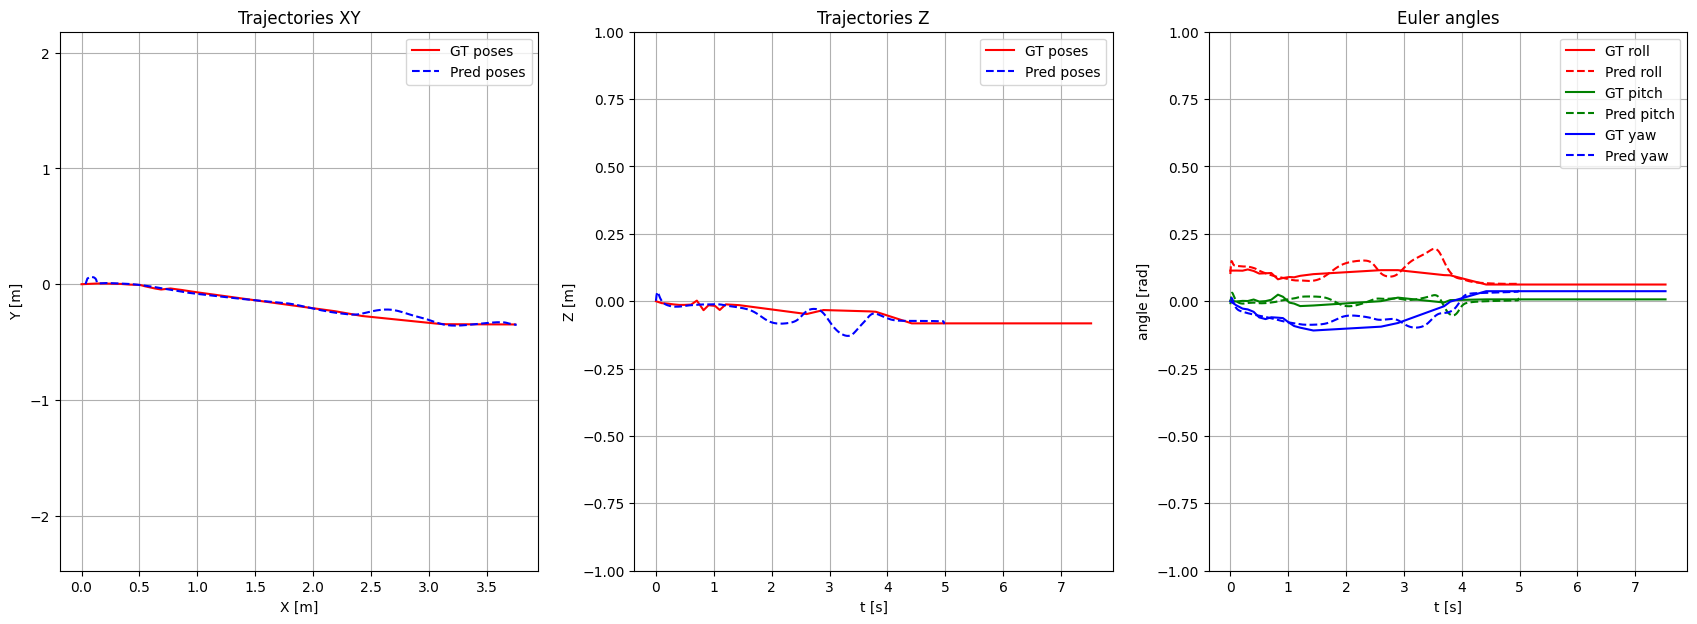

In [8]:
import matplotlib.pyplot as plt

# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Move tensors and model to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
batch = [b.to(device) for b in batch]
hm, control_ts, controls, traj_ts, xyz_rpy = batch
xyz_rpy0 = xyz_rpy[:, 0]

# Training loop
num_iters = 1000
for i in range(num_iters):
    optimizer.zero_grad()
    
    xyz_rpy_pred = model(xyz_rpy0, controls, hm)
    
    # find the closest timesteps in the trajectory to the ground truth timesteps
    ts_ids = torch.argmin(torch.abs(control_ts.unsqueeze(1) - traj_ts.unsqueeze(2)), dim=2)
    # compute the loss as the mean squared error between the predicted and ground truth poses
    loss = criterion(xyz_rpy_pred[torch.arange(batch_size).unsqueeze(1), ts_ids], xyz_rpy)
    
    loss.backward()
    optimizer.step()
    
    # visualization
    if i % 100 == 0 or i == num_iters - 1:
        print(f"Iter {i+1}/{num_iters}, Loss: {loss.item():.4f}")
        with torch.no_grad():
            plt.figure(figsize=(21, 7))
            plt.subplot(1, 3, 1)
            plt.plot(xyz_rpy[0, :, 0].cpu().numpy(), xyz_rpy[0, :, 1].cpu().numpy(), '-r', label='GT poses')
            plt.plot(xyz_rpy_pred[0, :, 0].cpu().numpy(), xyz_rpy_pred[0, :, 1].cpu().numpy(), '--b', label='Pred poses')
            plt.grid()
            plt.axis('equal')
            plt.legend()
            plt.title('Trajectories XY')
            plt.xlabel('X [m]')
            plt.ylabel('Y [m]')

            plt.subplot(1, 3, 2)
            plt.plot(traj_ts[0].cpu().numpy(), xyz_rpy[0, :, 2].cpu().numpy(), '-r', label='GT poses')
            plt.plot(control_ts[0].cpu().numpy(), xyz_rpy_pred[0, :, 2].cpu().numpy(), '--b', label='Pred poses')
            plt.grid()
            plt.ylim(-1, 1)
            plt.legend()
            plt.title('Trajectories Z')
            plt.xlabel('t [s]')
            plt.ylabel('Z [m]')

            plt.subplot(1, 3, 3)
            plt.title('Euler angles')
            plt.plot(traj_ts[0].cpu().numpy(), xyz_rpy[0, :, 3].cpu().numpy(), '-r', label='GT roll')
            plt.plot(control_ts[0].cpu().numpy(), xyz_rpy_pred[0, :, 3].cpu().numpy(), '--r', label='Pred roll')
            plt.plot(traj_ts[0].cpu().numpy(), xyz_rpy[0, :, 4].cpu().numpy(), '-g', label='GT pitch')
            plt.plot(control_ts[0].cpu().numpy(), xyz_rpy_pred[0, :, 4].cpu().numpy(), '--g', label='Pred pitch')
            plt.plot(traj_ts[0].cpu().numpy(), xyz_rpy[0, :, 5].cpu().numpy(), '-b', label='GT yaw')
            plt.plot(control_ts[0].cpu().numpy(), xyz_rpy_pred[0, :, 5].cpu().numpy(), '--b', label='Pred yaw')
            plt.ylim(-1, 1)
            plt.legend()
            plt.grid()
            plt.xlabel('t [s]')
            plt.ylabel('angle [rad]')
    
            plt.show()